In [11]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load and preprocess
# df = pd.read_csv('new_vega_rotation_overshooting_alpha_mlt_test_no_num_BIGGER_num_gt_180.csv')
# df = pd.read_csv('spica_lum_teff_box_2sigma_age_ge_1e6.csv')
df = pd.read_csv('spica_lum_teff_box_age_ge_1e6.csv')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['mass', 'z','fov','mlt', 'age', 'teff', 'lum']], df['log_k'], test_size=0.3, random_state=123)

#import test
import pickle
# Load the saved Random Forest model
with open('/home/research2/Downloads/HANNAH_SPICA_MESA_APSIDAL_CONSTANT_PROJECT_2024/MESA_READER_TEST/ML Methods/random_forest_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

# Load the saved Decision Tree model
with open('/home/research2/Downloads/HANNAH_SPICA_MESA_APSIDAL_CONSTANT_PROJECT_2024/MESA_READER_TEST/ML Methods/decision_tree_model.pkl', 'rb') as file:
    dt_model = pickle.load(file)


/home/research2/miniconda3/envs/mlexp/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/research2/miniconda3/envs/mlexp/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
# Calculating weights based on the features of the two models
model_dt_importance = np.array([0.0041, 0.0422, 0.0182, 0.0004, 0.4417, 0.4631, 0.2265]) 
model_rf_importance = np.array([0.0020, 0.0377, 0.0170, 0.0003, 0.4297, 0.4449, 0.2232])  

feature_weights_dt=model_dt_importance/(model_dt_importance + model_rf_importance)
feature_weights_rf=model_rf_importance/(model_dt_importance + model_rf_importance)

# Normalized and average weights across features
w_dt = np.mean(feature_weights_dt)
w_rf = np.mean(feature_weights_rf)

print(f"Weight for model DT: {w_dt}")
print(f"Weight for model RF: {w_rf}")

Weight for model DT: 0.544191712084811
Weight for model RF: 0.4558082879151891


In [13]:
# Create voting regressor with custom weights
voting_reg = VotingRegressor(
    estimators=[('rf', rf_model), ('dt', dt_model)],
    weights=[w_rf, w_dt] 
)

In [14]:
# Train the ensemble model
voting_reg.fit(X_train, y_train)

# Make predictions and evaluate
voting_reg_pred = voting_reg.predict(X_test)
print("Voting Regressor MSE:", f"{mean_squared_error(y_test, voting_reg_pred): .10f}")


Voting Regressor MSE:  0.0000056844


In [15]:
import keras.backend as K
from keras.utils import register_keras_serializable

# Register the r2 function so Keras can find it during unpickling
@register_keras_serializable()
def r2(y_true, y_pred):
    # Your R2 metric implementation
    pass

# Load the saved DL models
# Unpickle the saved FNN file
with open('/home/research2/Downloads/HANNAH_SPICA_MESA_APSIDAL_CONSTANT_PROJECT_2024/MESA_READER_TEST/NN Methods/FNN_model.pkl', 'rb') as model_file, open('/home/research2/Downloads/HANNAH_SPICA_MESA_APSIDAL_CONSTANT_PROJECT_2024/MESA_READER_TEST/NN Methods/FNN_scaler.pkl', 'rb') as scaler_file:
        fnn_model = pickle.load(model_file)
        fnn_scaler = pickle.load(scaler_file)

# Unpickle the saved RNN file
with open('/home/research2/Downloads/HANNAH_SPICA_MESA_APSIDAL_CONSTANT_PROJECT_2024/MESA_READER_TEST/NN Methods/RNN_model.pkl', 'rb') as model_file, open('/home/research2/Downloads/HANNAH_SPICA_MESA_APSIDAL_CONSTANT_PROJECT_2024/MESA_READER_TEST/NN Methods/RNN_scaler.pkl', 'rb') as scaler_file:
        rnn_model = pickle.load(model_file)
        rnn_scaler = pickle.load(scaler_file)

In [16]:
# We need both the model and the sclaer to get the correct prediction
X_test_scaled_fnn = fnn_scaler.transform(X_test)
fnn_preds = fnn_model.predict(X_test_scaled_fnn)

X_test_scaled_rnn = rnn_scaler.transform(X_test)
rnn_preds = rnn_model.predict(X_test_scaled_rnn)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [17]:
print("FNN MSE:", f"{mean_squared_error(y_test, fnn_preds): .10f}")
print("RNN MSE:", f"{mean_squared_error(y_test, rnn_preds): .10f}")


FNN MSE:  0.0000022781
RNN MSE:  0.0000243399


In [18]:
import numpy as np
#extracted feature importance values based on [mass, z, fov, mlt, age, teff, lum]

model_dt_importance = np.array([0.0041, 0.0422, 0.0182, 0.0004, 0.4417, 0.4631, 0.2265]) 
model_rf_importance = np.array([0.0020, 0.0377, 0.0170, 0.0003, 0.4297, 0.4449, 0.2232])  
model_fnn_importance = np.array([0.1993, 0.0357, 0.0000, 0.0002, 0.1272, 0.1363, 1.1614])  
model_rnn_importance = np.array([0.4625, 0.0203, 0.0000, 0.0002, 0.0015, 0.1894, 1.8882])  

feature_weights_dt=model_dt_importance/(model_dt_importance + model_rf_importance + model_fnn_importance + model_rnn_importance)
feature_weights_rf=model_rf_importance/(model_dt_importance + model_rf_importance + model_fnn_importance + model_rnn_importance)
feature_weights_fnn=model_fnn_importance/(model_dt_importance + model_rf_importance + model_fnn_importance + model_rnn_importance)
feature_weights_rnn=model_rnn_importance/(model_dt_importance + model_rf_importance + model_fnn_importance + model_rnn_importance)

# Average weights across features
w_dt = np.mean(feature_weights_dt)
w_rf = np.mean(feature_weights_rf)
w_fnn = np.mean(feature_weights_fnn)
w_rnn = np.mean(feature_weights_rnn)

print(f"Weight for model DT: {w_dt}")
print(f"Weight for model RF: {w_rf}")
print(f"Weight for model FNN: {w_fnn}")
print(f"Weight for model RNN: {w_rnn}")

Weight for model DT: 0.29701440839826054
Weight for model RF: 0.27002141085095
Weight for model FNN: 0.18749602884545327
Weight for model RNN: 0.24546815190533613


In [19]:
final_preds = (w_fnn * fnn_preds.ravel()) + (w_rnn * rnn_preds.ravel()) + ((w_dt+w_rf) * voting_reg_pred)
print("Ensemble MSE with all four:", f"{mean_squared_error(y_test, final_preds): .10f}")

# other metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print("Ensemble MAE with all four:", f"{mean_absolute_error(y_test, final_preds): .10f}")
print("Ensemble R² score with all four:", f"{r2_score(y_test, final_preds): .10f}")



Ensemble MSE with all four:  0.0000034645
Ensemble MAE with all four:  0.0014300862
Ensemble R² score with all four:  0.9962724396


Text(0.5, 1.0, 'Actual vs Predicted Values for Ensemble Method')

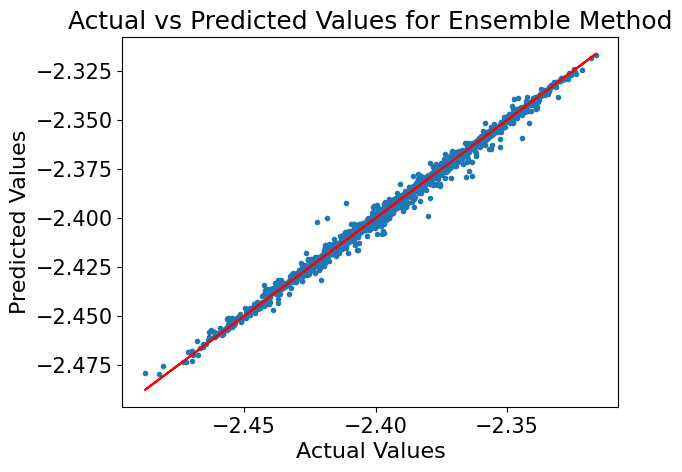

In [20]:
import matplotlib.pyplot as plt
fig, ax=plt.subplots()
ax.set_xlabel(r"Actual Values", fontsize=16)
ax.set_ylabel(r"Predicted Values", fontsize=16)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.plot(y_test, voting_reg_pred,'.')
ax.plot(y_test, y_test, color='r')
ax.set_title('Actual vs Predicted Values for Ensemble Method', fontsize=18)

In [37]:
#Test for a custom input

data={
    'mass': [15.5],
    'z': [0.02],
    'fov': [0.015],
    'mlt': [1.6],
    'age': [18323670.0],
    'teff': [25421.219513],
    'lum': [26590.3]
}
custom_x=pd.DataFrame(data)
print(custom_x)

custom_pred = voting_reg.predict(custom_x)
print("\nPredicted log_k: ", custom_pred)

   mass     z    fov  mlt         age          teff      lum
0  15.5  0.02  0.015  1.6  18323670.0  25421.219513  26590.3

Predicted log_k:  [-2.42238384]
